In [1]:
import numpy as np

import sympy
from sympy import *
from operator import mul
import mpmath as mp
from mpmath import fac
import functools
from sympy import init_printing
from sympy.core.decorators import _sympifyit, call_highest_priority
from IPython.display import display_latex
init_printing()
import copy
import collections

from functools import reduce  # Required in Python 3
import operator
#akin to built - in sum() but for product
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

In [14]:
sym_x, sym_y, sym_z, sym_px, sym_py, sym_pz, sym_beta, sym_k = sympy.symbols('x y z p_x p_y \delta beta k_Q')

In [3]:
class LieOperator(Expr):
    '''
    Defined algebra for the Lie operator:
    Addition: Hamiltonian functions get added into a new Lie operator
    Multiplication: Poisson bracket gets applied
    Exp: Lie Transfer Map gets applied
    BCH: Baker- Campbell - Hausdorff expansion gets applied as Lie Tranfer Map concatenation
    CAUTION: NOT ASSOCIATIVE

    INPUT: Hamiltonian, generalized coordinates and momenta
    '''
    
    
    _op_priority = 11.0

    is_commutative = False
    
    
    def __new__(cls, ham, indep_coords, indep_mom):
        if not isinstance(indep_coords, list): #create list of coords
            indep_coords = [indep_coords]
        if not isinstance(indep_mom, list): #create list of momenta
            indep_mom = [indep_mom]
        
        #same number of coordinates and momenta have to be entered
        assert(len(indep_coords)==len(indep_mom)),'The number of coords and momenta is not the same'
            
        obj = Expr.__new__(cls, ham, indep_coords, indep_mom)
        obj._ham = ham
        obj._indep_coords = indep_coords
        obj._indep_mom = indep_mom
        return obj
    
    
    @property
    def ham(self):
        return self._ham
    
    @ham.setter
    def ham(self, other):
        #Input has to be a function
        assert(not(S(ham.is_number))), 'Input has to be a function and not a number'
        self._ham = self._ham.subs(self.ham, other).doit()
        
    @property
    def indep_coords(self):
        return self._indep_coords
    
    @indep_coords.setter
    def indep_coords(self, other):
        self._indep_coords = other
        
    @property
    def indep_mom(self):
        return self._indep_mom
    
    @indep_mom.setter
    def indep_mom(self, other):
        self._indep_mom = other
        
        
        
    
    #Algebraic properties 

    #Define Addition
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__radd__')
    def __add__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__add__')
    def __radd__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)
    
    #Define Substraction
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rsub__')
    def __sub__(self, other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham - other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__sub__')
    def __rsub__(self, other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham - other.ham, self.indep_coords,self.indep_mom)
        
    #Define Multiplication
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rmul__')
    def __mul__(self, other):
        return self.LieOperatorMul(other)
        
        
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__mul__')
    def __rmul__(self,other):
        if S(other).is_number:
            return LieOperator(other*self.ham,self.indep_coords,self.indep_mom)
        elif not isinstance(other, LieOperator):
            other = LieOperator(other,self.indep_coords,self.indep_mom) 
        return other.LieOperatorMul(self)
    
    
    def LieOperatorMul(_ham1, _ham2):
        if not isinstance(_ham2, LieOperator):
            _ham2 = LieOperator(_ham2,_ham1.indep_coords,_ham1.indep_mom) 
        if not collections.Counter(_ham1.indep_coords) == collections.Counter(_ham2.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return _ham1.Poisson(_ham2)
    
    
    #Calcualte Poisson bracket with input function
    def Poisson(self,other):
        _h1 = self.ham
        _h2 = other.ham
        hp = S(0)
        for qi,pi in zip(self.indep_coords, self.indep_mom):
            hp += _h1.diff(qi) * _h2.diff(pi) 
            hp -= _h1.diff(pi) * _h2.diff(qi)
        return LieOperator(hp,self.indep_coords,self.indep_mom)
    
    
    #Exponential Map: Lie Transform Map
    #Calculate the exponential map of the Lie operator to the input cutoff
    def LieMap(self,other,power):
        s = S(0)
        
        for i in range(power+1):
            s += sympy.Rational(1,factorial(i))*(self.ExpPowerLieBracket(other,i)).ham
        
        return LieOperator(s,self.indep_coords,self.indep_mom) 
    
    
    
    #Successively apply Poisson bracket to input function to the input cutoff
    def ExpPowerLieBracket(self, other, power):
        _op1 = self
        _op2 = other
        
        
        if power > 0:
            hp = _op1*_op2
            
            for s in range(1,power):
                hp = _op1*hp
                
        else:
            if not isinstance(_op2, LieOperator):
                _op2 = LieOperator(_op2, self.indep_coords,self.indep_mom)
            
            hp = _op2
        
        return hp
    
    #Up to order 4 done manually to have a working copy, arbitrary ordered needs to be still written
    def BCH(self,other,n):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        elif n < 1:
            raise ValueError(n, ' is not a valid order. Number has to be natural.')
            
        _op1 = LieOperator(self.ham,self.indep_coords, self.indep_mom)
        _op2 = LieOperator(other.ham, other.indep_coords, other.indep_mom)
        
        
        temp = _op1 + _op2
        
        if n > 1:
            _xy = _op1 * _op2
            _yx = _op2 * _op1
            temp = temp + sympy.Rational(1,2) * _xy
        
        if n > 2:
            _xxy = _op1 * _xy
            _yyx = _op2 * _yx
            temp = temp + sympy.Rational(1,12) * _xxy + sympy.Rational(1,12) * _yyx
           
        if n > 3:
            _yxxy = _op2 * _xxy 
            temp = temp  - sympy.Rational(1,24) * _yxxy
        
        if n > 4:
            _xyxyx = _op1 * (_op2 * (_op1 * _yx))
            _yxyxy = _op2 * (_op1 * (_op2 * _xy))
            
            _xxxy = _op1 * _xxy
            _yyyx = _op2 * _yyx
            temp = temp + (sympy.Rational(1,120) * _xyxyx
                           + sympy.Rational(1,120) * _yxyxy
                           + sympy.Rational(1,360) * _op1 * _yyyx
                           + sympy.Rational(1,360) * _op2 * _xxxy
                           - sympy.Rational(1,720) * _op2 * _yyyx
                           - sympy.Rational(1,720) * _op1 * _xxxy
                          )
       
        return temp

In [4]:
sym_x, sym_y, sym_z, sym_px, sym_py, sym_pz = sympy.symbols('x y z p_x p_y \delta')

def factorization(taylor): #Dragt-Finn factorization from taylor map vector
    LieProduct = []
    degree = 0
    
    for polynomial in taylor:
        comp_degree = poly(polynomial).total_degree() #highest degree of hom poly in Lie map
        if degree <= comp_degree:
            degree = comp_degree

    for i in range(2,degree+2):
        T = taylor_to_lie(taylor, i) #coeff match to get hom poly in Lie product maps
        LieProduct.append(T) #Lie maps product as array
        taylor = transform_taylor(T, taylor, i, degree) #adjust higher order taylor coeff for next coeff extraction

        if i > 5:
            print('Implemented only to 5th order so far.')
            break
            
    return LieProduct



def taylor_to_lie(taylor,degree): #decide if linear or nonlinear
    
    if degree == 2:
        f = deg2_lie(taylor) #linear case
        
    else:
        f = degN_lie(taylor,degree) #higher order maps
    
    return f



def deg2_lie(taylor): #extract matrix from linear part of the taylor polynomial
    I = np.identity(6)
    R = []
    i = len(taylor)

    for polynomial in taylor:
        p = poly(polynomial, sym_x,sym_px,sym_y,sym_py,sym_z,sym_pz)
        monomials = p.monoms()
        coeffs = p.coeffs()
        
        Matrow = []
        for j,row in enumerate(I):
            try:
                index = monomials.index(tuple(row))
                Matrow.append(coeffs[index])
            except:
                if j < i: #make sure the matrix stays quadratic
                    Matrow.append(0)

        R.append(Matrow)
        
    
    R = np.asarray(R, dtype='float') #convert to numpy so linalg can invert it
    
    return R



def degN_lie(taylor, degree): #higher order Lie maps
    _epstemp = sympy.symbols('e')
    variables = (sym_x, sym_px, sym_y, sym_py, sym_z, sym_pz)
    derivatives = (1,0,3,2,5,4) #order: d/dpx, d/dx, d/dpy, d/dy, d/dz, d/dz
    f = poly(0, sym_x,sym_px,sym_y,sym_py,sym_z,sym_pz) #Lie map hom poly generated from taylor
    
    for var,polynomial in enumerate(taylor):
        p = poly(polynomial, sym_x,sym_px,sym_y,sym_py,sym_z,sym_pz) #make it a sympy polynomial
        order = [sum(mon) for mon in p.monoms()] #array of monomial degrees
        for index,monomial in enumerate(p.monoms()): #iterate over all monomials in taylor
            if order[index] == (degree-1): #check hom level -> derivative is order - 1
#                 print(variables,monomial)
                mon = prod(a**b for a,b in zip(variables,monomial)) #reconstruct monomial
                if (f.coeff_monomial(mon * variables[derivatives[var]])) == 0: #avoid double sum of same coeff
                    power = monomial[derivatives[var]] #normalize derivative power
                    f = f + (p.coeffs()[index] / (power+1)) * mon * variables[derivatives[var]] * (-1)**(var)
                    
    return f.subs(_epstemp,0)



def transform_taylor(ham, taylor, hom_order, degree=3): #adjust higher order coeffs
    #getaround for .subs() being iterative
    sym_x1, sym_y1, sym_z1, sym_px1, sym_py1, sym_pz1 = sympy.symbols('x_1 y_1 z_1 p_{x1} p_{y1} \delta_1')
    variables = (sym_x, sym_px, sym_y, sym_py, sym_z, sym_pz)
    new_variables = (sym_x1, sym_px1, sym_y1, sym_py1, sym_z1, sym_pz1)
    
    if hom_order == 2: #linear case needs more checking
        R_inv = np.linalg.inv(ham)
        vec = [new_variables[i] for i in range(len(R_inv))]
        
        new_coords = np.dot(R_inv, vec) #exp(-:G_2:) z_1 = z_0 + higher orders
        int_taylor = [polynomial.subs([(i,j) for i,j in zip(variables,new_coords)]) for polynomial in taylor]
        taylor = [polynomial.subs([(i,j) for i,j in zip(vec,variables)]) for polynomial in int_taylor]
    else: #higher order
        LiePoly = LieOperator(-ham,[sym_x,sym_y,sym_z],[sym_px,sym_py,sym_pz]) #use hom poly ham of degree = hom_order
        mod_taylor = taylorize(LiePoly, degree+1) #create symplectic jet to adjust the coeffs of taylor polynomial
        taylor = [old_poly - new_poly for old_poly,new_poly in zip(taylor,mod_taylor)] #exp(-:G_n:)z -> subtract from taylor poly the symplectic jet
    
    return taylor

def taylorize(LieHam, degree): #Apply Lie map to get taylor map vector on 6d vector
    taylor_maps = []
    
    for i in LieHam.indep_coords:
        fct = LieHam.LieMap(i,degree)
        fct = truncate(fct,degree)
        
        taylor_maps.append(fct.expand())
        
    for i in LieHam.indep_mom:
        fct = LieHam.LieMap(i,degree)
        fct = truncate(fct,degree)
        
        taylor_maps.append(fct.expand())
    
    # reorder taylor maps to x, px, y, py, z, pz
    if len(LieHam.indep_coords) == 2:
        taylor_maps[1], taylor_maps[2] = taylor_maps[2], taylor_maps[1] #swtich y and px
        
    elif len(LieHam.indep_coords) == 3:
        taylor_maps[1], taylor_maps[3] = taylor_maps[3], taylor_maps[1] #swtich y and px
        taylor_maps[2], taylor_maps[3] = taylor_maps[3], taylor_maps[2] #switch z and y
        taylor_maps[3], taylor_maps[4] = taylor_maps[4], taylor_maps[3] #switch z and py
    
    return taylor_maps



def truncate(LieHam,degree): #cutoff Hamiltonian at specified degree
    _epstemp = sympy.symbols('e')
    fct = LieHam.ham
    
    for i in LieHam.indep_coords:
        fct = fct.subs(i,i*_epstemp)
        
    for i in LieHam.indep_mom:
        fct = fct.subs(i,i*_epstemp)
    
    fct = fct.expand() + O(_epstemp**degree)
    fct = fct.removeO().subs(_epstemp,1)
    
    return fct

def getKronPowers(state, order, dim_reduction = True):
    """Calculates Kroneker powers of state vector
       with dimension reduction

    e.g. for (x y) and order=2 returns:
    1, (x y), (x x*y y)  

    Returns:
    list of numpy arrays, index corresponds to power 
    """
    powers = [state]
    index = [np.ones(len(state), dtype=bool)]
    for i in range(order-1):
        state_i = np.kron(powers[-1], state)
        reduced, red_ind = cust_reduce(state_i)
        if dim_reduction:
            powers.append(reduced)
        else:
            powers.append(state_i)
            
        index.append(red_ind)

    powers.insert(0, np.array([1]))
    index.insert(0, [True])
    return powers, index 

def cust_reduce(state):
    state_str = state.astype(str)
    reduced_state = []
    unique = []

    index = []
    for variable, variable_str in zip(state, state_str):
        if variable_str not in unique:
            unique.append(variable_str)
            index.append(True)
            reduced_state.append(variable)
        else:
            index.append(False)

    return np.array(reduced_state), index


def taylor_to_weight_mat(_taylor):
    degree = 0
    for polynomial in _taylor:
            comp_degree = poly(polynomial).total_degree() #highest degree of hom poly in Lie map
            if degree <= comp_degree:
                degree = comp_degree

    if len(_taylor) == 2:
        coords = [sym_x,sym_px]
    elif len(_taylor) == 4:
        coords = [sym_x,sym_px,sym_y,sym_py]
    elif len(_taylor) == 6:
        coords = [sym_x,sym_px,sym_y,sym_py,sym_z,sym_pz]
    else:
        raise TypeError('The dimension of the Taylor map vector does not match the phase space.')

    state_vectors, index = getKronPowers(coords,degree,dim_reduction=False)
    
#     print(state_vectors)

    W = []

    for i in range(degree+1):
        if i == 0:
#             print("Displacement not yet programmed.")
            continue

        w_sub = np.zeros((len(_taylor),len(state_vectors[i])))

        for j, taylor_row in enumerate(_taylor):
            taylor_sub = poly(taylor_row, state_vectors[1])

            for k, (state_vector, flag) in enumerate(zip(state_vectors[i],index[i])):
                coeff = taylor_sub.coeff_monomial(state_vector)

                if coeff != 0 and flag == True:
                    w_sub[j,k] = coeff
        W.append(w_sub.T)
    
    return W

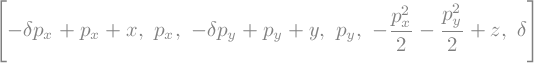

In [15]:
i_coord = [sym_x,sym_y,sym_z]
i_mom = [sym_px,sym_py,sym_pz]


_epstemp = sympy.symbols('e')
approx_degree = 4
approx_degree_quad = 3

full_drift = sym_pz/sym_beta - sqrt((1/sym_beta + sym_pz)**2 - (sym_px ** 2 + sym_py ** 2) + 1 - 1/sym_beta**2)
arg = (1/sym_beta + sym_pz)**2 - (sym_px ** 2 + sym_py ** 2) + 1 - 1/sym_beta**2
sub0 = list(zip([sym_px,sym_py,sym_pz],[_epstemp*sym_px,_epstemp*sym_py,_epstemp*sym_pz]))
HD = sym_pz/sym_beta - sympy.series(sqrt(sympy.simplify(arg)).subs(sub0),_epstemp,0,approx_degree).removeO().subs(_epstemp,1)
HQ = sym_pz/sym_beta - sympy.series(sqrt(sympy.simplify(arg)).subs(sub0),_epstemp,0,approx_degree_quad).removeO().subs(_epstemp,1)
drift_sr = HD.subs(sym_beta,1)
quad_sr = HQ.subs(sym_beta,1) + sym_k*(sym_x**2 - sym_y**2)/2


H_drift = drift_sr
H_quad = quad_sr


Lh = LieOperator(-H_drift,i_coord,i_mom)
taylor_vector = taylorize(Lh,5)
taylor_vector

In [18]:
len(taylor_vector)

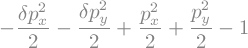

In [16]:
H_drift

In [8]:
# F = factorization(taylor_vector)
# F

KeyboardInterrupt: 

In [17]:
taylor_to_weight_mat(taylor_vector)

[array([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]]),
 array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. , -0.5,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [-1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0.